<a href="https://colab.research.google.com/github/DrAlexSanz/Bio-circuits/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the notebook for Chapter 2

[Cascades](http://be150.caltech.edu/2020/content/lessons/02_intro_to_python_for_biological_circuits.html)

This deals with systems in which X causes Y, which causes Z. Importantly, X, Y and Z are concentrations (g/l) or equivalent units.

$$ X → Y → Z $$

We assume that the equations that govern this kind of system are shown below.

* x is the concentration of the first molecule. $γ_y$ is the rate of production of x, starting from y. $γ_z$ is the rate of production of z from y.

* $k_x$ is the repression coefficient. This represents the time when the concentration of x gets reduced to half of the initial value. It's similar to the half-life in radioactive particles but with concentrations.

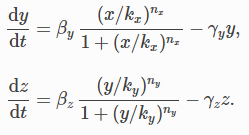

Now we can make these equations adimensional. It's more convenient and makes everythin easier to solve. We will work in p.u.

This is the change of base:

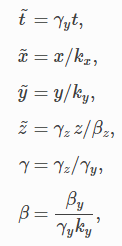

And this is the resulting system of equations:

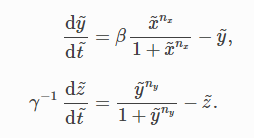

Finally, we remove the tildes for simplicity of notation:

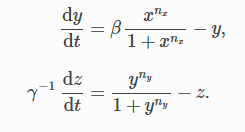



In [1]:
# Import things

import numpy as np
import scipy.integrate

import bokeh.io
import bokeh.plotting

import panel as pn

import colorcet

bokeh.io.output_notebook()
pn.extension()

Let's start solving an initial value problem.

At time 0 we suddenly have a concentration $x_0$ of x, let's see the evolution.

Parameters for the right hand side:
* $β_y, β_z$.
* $γ$.
* $n_x, n_y$.
* $x_0$.


In [2]:
# Let's define a function that produces the right hand side of the equations above.

def cascade_rhs(yz, t, beta, gamma, n_x, n_y, x):
    """
    Right hand side for cascade equations above
    """

    # unpack y and z. odeint wants a vector

    y, z = yz

    dy_dt = beta * x**n_x / (1 + x**n_x) - y

    dz_dt = gamma * (y**n_y / (1 + y**n_y) - z)

    # Now make a vector
    eqs = np.array([dy_dt, dz_dt])

    return eqs
   

In [4]:
# Number of time steps
n = 400
t = np.linspace(0, 10, n)

# Initial conditions

yz_0 = np.array([0.0, 0.0])

# Parameters. I'm putting here whatever I feel like
beta = 1.0
gamma = 1.0
n_x = 2
n_y = 2
x_0 = 2.0

# Package these arguments for integration
args = (beta, gamma, n_x, n_y, x_0)

# Integrate the system of ODEs

yz = scipy.integrate.odeint(cascade_rhs, yz_0, t, args = args)

In [5]:
# Check the output

yz.shape # First column will be y(t) and the second column is z(t).

(400, 2)

Now plot the response. Put the solver inside the plotting function for dynamical plots.

In [6]:
colors = colorcet.b_glasbey_category10

In [20]:
# Let's build the sliders first and add a decorator to the function

log_beta_slider = pn.widgets.FloatSlider(
    name = "log_beta", start = -1, end = 20, step = 0.1, value = 0
)

log_gamma_slider = pn.widgets.FloatSlider(
    name = "log_gamma", start = -1, end = 20, step = 0.1, value = 0
)

log_x0_slider = pn.widgets.FloatSlider(
    name = "log_x_0", start = -1, end = 20, step = 0.1, value = 0
)

nx_slider = pn.widgets.FloatSlider(
    name = "n_x", start = -1, end = 20, step = 0.1, value = 0
)

ny_slider = pn.widgets.FloatSlider(
    name = "n_y", start = -1, end = 20, step = 0.1, value = 0
)

t_max_slider = pn.widgets.FloatSlider(
    name = "t_max", start = 1, end = 20, step = 0.1, value = 10
)

# And the normalize parameter is not continuous, it's a boolean

normalize_checkbox = pn.widgets.Checkbox(name = "Normalize", value = False)

In [21]:
@pn.depends(
    log_beta_slider.param.value,
    log_gamma_slider.param.value,
    nx_slider.param.value,
    ny_slider.param.value,
    log_x0_slider.param.value,
    t_max_slider.param.value,
    normalize_checkbox.param.value
)

def cascade_response_plot(log_beta = 0, log_gamma = 0, n_x = 2, n_y = 2, log_x0 = np.log10(2), t_max = 10, normalize = False, n = 400):

    # package parameters
    args = (10**log_beta, 10**log_gamma, n_x, n_y, 10**log_x0)

    # Integrate ODEs

    t = np.linspace(0, t_max, n)

    yz = scipy.integrate.odeint(cascade_rhs, yz_0, t, args = args)
    y, z = yz.transpose()

    # Normalize if selected
    if normalize:
        y = y / y.max()
        z = z / z.max()

    # Set up the plot

    p = bokeh.plotting.figure(
        frame_width = 325,
        frame_height = 250,
        x_axis_label = "Time [a. u.]",
        y_axis_label = f"{'normalized' if normalize else ''}y, z [a.u.]",
        x_range = [0, t_max]
    )

    # Now draw
    p.line(t, y, line_width = 2, color = colors[0], legend_label = "y")
    p.line(t, z, line_width = 2, color = colors[1], legend_label = "z")
    p.legend.location = "bottom_right"

    return p


In [22]:
widgets = pn.Column(
    pn.Spacer(height = 10),
    log_beta_slider,
    log_gamma_slider,
    nx_slider,
    ny_slider,
    t_max_slider,
    log_x0_slider,
    width = 150
)

left_column = pn.Column(
    pn.Row(pn.Spacer(width = 30), normalize_checkbox), cascade_response_plot
)

pn.Row(left_column, pn.Spacer(width = 20), widgets)

Row
    [0] Column
        [0] Row
            [0] Spacer(width=30)
            [1] Checkbox(name='Normalize')
        [1] ParamFunction(function, _pane=Bokeh)
    [1] Spacer(width=20)
    [2] Column(width=150)
        [0] Spacer(height=10)
        [1] FloatSlider(end=20, name='log_beta', start=-1)
        [2] FloatSlider(end=20, name='log_gamma', start=-1)
        [3] FloatSlider(end=20, name='n_x', start=-1)
        [4] FloatSlider(end=20, name='n_y', start=-1)
        [5] FloatSlider(end=20, name='t_max', start=1, value=10)
        [6] FloatSlider(end=20, name='log_x_0', start=-1)